# Supervised prediction of prokaryotic cell size

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sklearn
sklearn.__version__

'1.3.2'

## Input data

Pathway names and member genes

In [3]:
genes_pathways = {}
with open('../genomic_analyses/function/kegg/pathways_genes.txt', 'r') as f:
    for line in f:
        ptw, gene = line.rstrip().split(',')
        genes_pathways.setdefault(ptw, []).append(gene)

In [4]:
with open('../genomic_analyses/function/kegg/pathways_curated.txt', 'r') as f:
    description_pathways = dict(x.split('\t') for x in f.read().splitlines())

Data frame

In [5]:
df = pd.read_table('for_rf.tsv', index_col = 0)
df.shape

(1361, 1077)

In [6]:
df['log_genome'] = np.log10(df['genome'])
df['log_proteins'] = np.log10(df['proteins'])
df['arc_coding'] = np.arcsin(np.sqrt(df['coding'] / 100))
df['arc_gc'] = np.arcsin(np.sqrt(df['gc'] / 100))

In [7]:
df.columns

Index(['length', 'width', 'volume', 'surface', 'shape', 'species', 'genus',
       'family', 'order', 'class',
       ...
       'hits_all_bp_genome_size_ko02026', 'hits_all_bp_genome_size_ko02030',
       'hits_all_bp_genome_size_ko02040', 'hits_all_bp_genome_size_ko04112',
       'hits_all_bp_genome_size_ko04110', 'hits_all_bp_genome_size_ko04810',
       'log_genome', 'log_proteins', 'arc_coding', 'arc_gc'],
      dtype='object', length=1081)

**Columns necessary (I think) for RF regression**

* Log volume-to-surface ratio: `log_svratio`
* Genome traits:
    * Log genome size: `log_genome`
    * Log number of proteins: `log_proteins`
    * GC content (arcsine transformed): `arc_gc`
    * COding density (arcsine transformed): `arc_coding`
    * NUmber of 16S rRNAs: `rrnas`
    * COdon bias: `ENCprime`
* Phylogenetic information (given its importance for cell size): Previously, I used a metric that quantifies the relatedness of species, as the **geometric mean** of the patristic distance of one species to all others. But I am not sure if this is the best metric for this
*  **263** KEGG pathways: not all pathways are relevant for prokaryotes.
* We used four metrics to quantify the contribution of each pathway. I think only one metric will do the trick:
    1. Different number of proteins in pathway: `hits_different_x` where x is KEGG code of pathway (koXXXXX)
    2. Total number of proteins in pathway: `hits_all_x` where x is KEGG code of pathway (koXXXXX)
    3. Total number of base pairs of all proteins in pathway: `hits_all_bp_x` where x is KEGG code of pathway (koXXXXX)
    4. Fraction of total number of base pairs of all proteins in pathway divided by genome size: `hits_all_bp_genome_size_x` where x is KEGG code of pathway (koXXXXX)
    

**Some additional information** 


* The pathways names from `description_pathways` which is a dictionary with KEGG codes as keys and pathway name as values. 


* The number of genes in a pathaye can be accessed from `genes_pathways` which is a dictionary with KEGG codes as keys and KEGG orthologs as values (list), so the number of genes is simply `len(genes_pathways[koXXXXX])`.

Let's say I want to use metric number **1**

In [8]:
assert len(df.columns[df.columns.str.contains(rf'^hits_different')]) == 263

And genome traits

In [9]:
gtraits = 'log_genome|log_proteins|arc_gc|arc_coding|rrnas|ENCprime'

In [10]:
assert len(df.columns[df.columns.str.contains(rf'{gtraits}')]) == 6

Both KEGG pathways (metric 1) and genome traits

In [11]:
new_cols = df.columns[df.columns.str.contains(rf'^hits_all_bp_genome_size|{gtraits}')]

In [12]:
df1 = df[new_cols]
df1.head()

,rrnas,ENCprime,hits_all_bp_genome_size_ko01110,hits_all_bp_genome_size_ko01120,hits_all_bp_genome_size_ko01200,hits_all_bp_genome_size_ko01210,hits_all_bp_genome_size_ko01212,hits_all_bp_genome_size_ko01230,hits_all_bp_genome_size_ko01232,hits_all_bp_genome_size_ko01250,...,hits_all_bp_genome_size_ko02026,hits_all_bp_genome_size_ko02030,hits_all_bp_genome_size_ko02040,hits_all_bp_genome_size_ko04112,hits_all_bp_genome_size_ko04110,hits_all_bp_genome_size_ko04810,log_genome,log_proteins,arc_coding,arc_gc
taxid,,,,,,,,,,,,,,,,,,,,,
taxid44676,3.0,0.098432,0.080228,0.056344,0.035351,0.007677,0.011838,0.031194,0.007933,0.007646,...,0.003939,0.004267,0.001344,0.011375,0.0,0.0,6.517171,3.466126,1.269896,0.979108
taxid290732,5.0,0.029022,0.076692,0.042198,0.026263,0.011642,0.002262,0.038055,0.008714,0.012010,...,0.002791,0.018629,0.013140,0.005732,0.0,0.0,6.508289,3.448861,1.192745,0.890265
taxid29508,1.0,0.136040,0.059437,0.033179,0.019644,0.005485,0.006283,0.021868,0.005575,0.007460,...,0.002108,0.020427,0.010071,0.003569,0.0,0.0,6.622013,3.591843,1.307423,0.664524
taxid174,2.0,0.090332,0.053840,0.027905,0.019793,0.005724,0.005704,0.021446,0.005825,0.007845,...,0.000947,0.011577,0.011004,0.003717,0.0,0.0,6.594589,3.557748,1.132138,0.687066
taxid100053,1.0,0.091161,0.048493,0.025605,0.017835,0.005036,0.004951,0.019715,0.004893,0.008664,...,0.000881,0.011568,0.009909,0.002861,0.0,0.0,6.625706,3.607348,1.148166,0.686760


In [13]:
df1.to_csv('data.tsv', sep = '\t')

## Train and test set

Random state

In [14]:
np.random.seed(42)

Data: KEGG pathways (metric 1) and genome traits

In [15]:
X = df1.to_numpy()

Target: log(S/V-ratio)

In [16]:
y = df['log_svratio'].to_numpy()

Split data into training and test sets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Keep indices
# X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(df1, df['log_svratio'], test_size = 0.3, random_state = 42)

In [19]:
X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(df1, df['log_svratio'], test_size = 0.3, random_state = 42)

In [20]:
X.shape

(1361, 269)

In [21]:
X_train.shape

(952, 269)

In [22]:
X_test.shape

(409, 269)

Dummy regressor using the mean

In [23]:
from sklearn.dummy import DummyRegressor

In [24]:
dummy_reg = DummyRegressor(strategy = 'mean')
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [25]:
y_dummy = dummy_reg.predict(X_test)

In [26]:
r2 = 1 - np.sum((y_test - y_dummy) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
r2

-0.004906484634656927

## Supervised regression

Create a random forest regressor on standardized data

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [20]:
pipe = Pipeline(steps=[
    ('std', StandardScaler()),
    ('reg', RandomForestRegressor())])

Train model with default parameters

In [21]:
from sklearn.base import clone

In [22]:
model = clone(pipe)

In [23]:
%%time
model.fit(X_train, y_train)

CPU times: user 19.7 s, sys: 14.9 ms, total: 19.7 s
Wall time: 19.7 s


Pipeline(steps=[('std', StandardScaler()), ('reg', RandomForestRegressor())])

Evaluate model performance using MSE and MAE

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [25]:
y_pred = model.predict(X_test)

In [26]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.03056621174113047
MAE: 0.1277385183480118
R2: 0.43326464213427407


Assess feature importance

In [27]:
feat_importances = pd.Series(model['reg'].feature_importances_, index = new_cols)
feat_importances.sort_values(ascending = False, inplace = True)
feat_importances.head(n = 10)

hits_all_bp_genome_size_ko00196    0.143435
arc_coding                         0.061942
hits_all_bp_genome_size_ko02020    0.018809
hits_all_bp_genome_size_ko01212    0.018662
hits_all_bp_genome_size_ko03250    0.016888
hits_all_bp_genome_size_ko04141    0.016830
hits_all_bp_genome_size_ko04151    0.012641
hits_all_bp_genome_size_ko00460    0.011866
hits_all_bp_genome_size_ko00030    0.010644
hits_all_bp_genome_size_ko00543    0.010643
dtype: float64

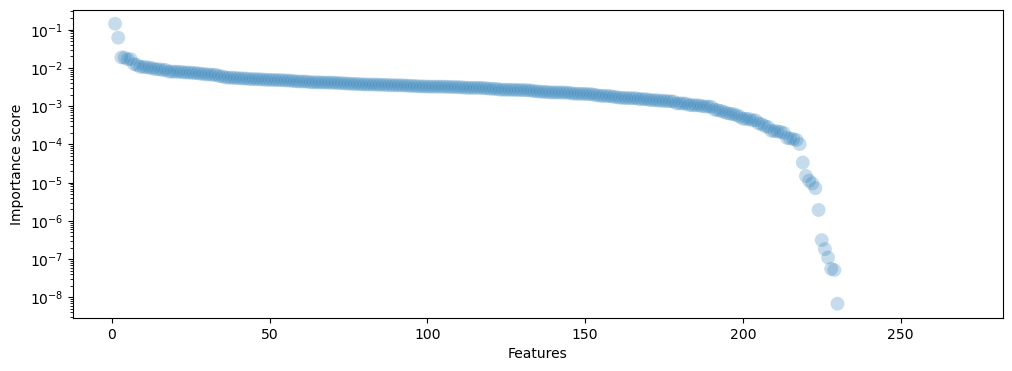

In [28]:
plt.figure(figsize = (12, 4))
plt.scatter(np.arange(len(feat_importances)) + 1, feat_importances.values, s = 100, alpha = 0.25, ec = 'none')
plt.xlabel('Features')
plt.ylabel('Importance score')
# plt.xscale('log')
plt.yscale('log')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

## Feature importance

Calculate feature importance using 10 repeats of 5-fold cross validation

In [29]:
from sklearn.model_selection import RepeatedKFold

In [30]:
cv = RepeatedKFold(n_splits = 5, n_repeats = 10)

In [31]:
feat_importances = []
for idx, _ in cv.split(X_train):
    model = clone(pipe).fit(X_train[idx], y_train[idx])
    feat_importances.append(model['reg'].feature_importances_)

In [32]:
df_fi = pd.DataFrame(feat_importances, columns = new_cols)

In [33]:
df_desc = df_fi.describe().T

In [34]:
df_desc[['mean', 'std']].to_csv('importance.tsv', sep = '\t')

In [35]:
df_desc.sort_values('mean', ascending = False, inplace = True)
df_desc.head()

,count,mean,std,min,25%,50%,75%,max
hits_all_bp_genome_size_ko00196,50.0,0.152067,0.020275,0.099711,0.141756,0.153390,0.167973,0.189430
arc_coding,50.0,0.055251,0.010546,0.035735,0.048937,0.054275,0.062347,0.079999
hits_all_bp_genome_size_ko02020,50.0,0.019032,0.012333,0.003336,0.009690,0.015714,0.023571,0.060179
hits_all_bp_genome_size_ko04141,50.0,0.015525,0.006880,0.003637,0.010967,0.014702,0.019354,0.034050
hits_all_bp_genome_size_ko00030,50.0,0.015134,0.004877,0.005660,0.011946,0.014882,0.017540,0.030481


Drop low-importance features

In [36]:
df_desc.query('mean >= 0.005', inplace = True)

In [37]:
means = df_desc['mean']
stds = df_desc['std']
n = df_desc.shape[0]
xrange = np.arange(n)

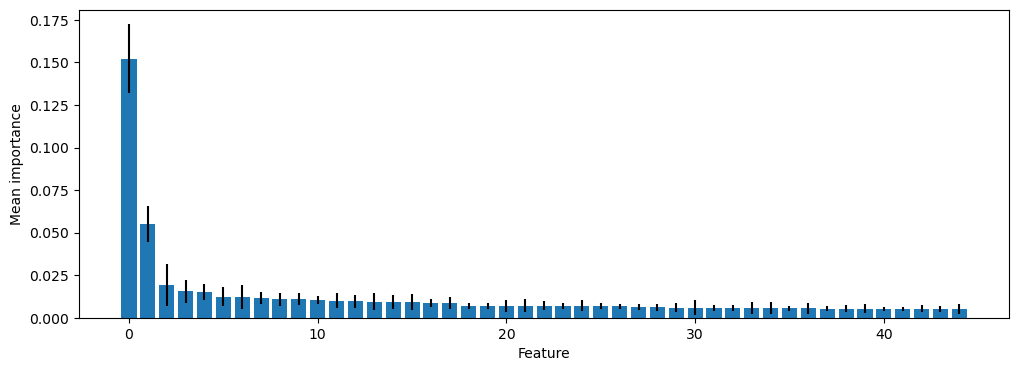

In [38]:
plt.figure(figsize = (12, 4))
plt.bar(xrange, means)
plt.errorbar(xrange, means, yerr = stds, fmt = 'none', color = 'k')
plt.xlabel('Feature')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylabel('Mean importance')
plt.savefig('../figures_all/importance.svg')

**Add KO labels to each feature**

## Feature selection

Recursive feature elimination with cross-validation

In [39]:
from sklearn.feature_selection import RFECV

In [40]:
selector = RFECV(pipe, step = 1, cv = cv,
                 scoring = 'r2',
                 importance_getter = 'named_steps.reg.feature_importances_',
                 n_jobs = 24)

In [41]:
%%time
selector.fit(X_train, y_train)

CPU times: user 20min 18s, sys: 4.69 s, total: 20min 22s
Wall time: 2h 22min 6s


RFECV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
      estimator=Pipeline(steps=[('std', StandardScaler()),
                                ('reg', RandomForestRegressor())]),
      importance_getter='named_steps.reg.feature_importances_', n_jobs=24,
      scoring='r2')

Number of original features

In [42]:
selector.n_features_in_

269

Number of remaining features

In [43]:
selector.n_features_

209

Plot feature count vs. model performance

In [44]:
means = selector.cv_results_['mean_test_score']
stds = selector.cv_results_['std_test_score']
xbeg = selector.min_features_to_select
xend = xbeg + len(means)
xrange = np.arange(xbeg, xend)
step = 25
xticks = np.arange(np.floor(xbeg / step), np.ceil(xend / step) + 1).astype(int) * step

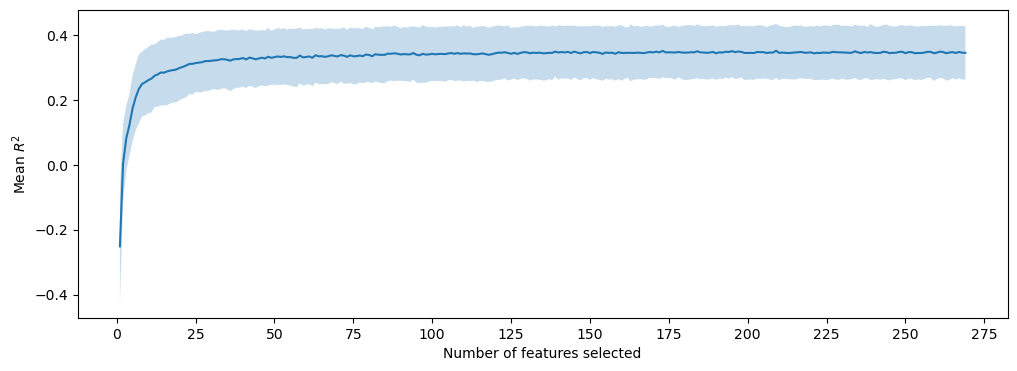

In [45]:
plt.figure(figsize = (12, 4))
plt.plot(xrange, means)
plt.fill_between(xrange, means - stds, means + stds, alpha = 0.25)
plt.xticks(xticks, xticks)
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlabel('Number of features selected')
plt.ylabel('Mean $R^2$')
plt.savefig('../figures_all/rfecv.svg')

Save result to file. Format: 1 - selected, 0 - discarded

In [46]:
np.savetxt('rfecv.txt', selector.support_, fmt = '%d')

Filter data to selected features

In [47]:
X_train_filt = X_train[:, selector.support_]
X_test_filt = X_test[:, selector.support_]

Use the filtered data to train model and evaluate performance

In [48]:
model = clone(pipe).fit(X_train_filt, y_train)
y_pred = model.predict(X_test_filt)

In [49]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.030159990487044284
MAE: 0.1270985287178757
R2: 0.44079648643859826


## Hyperparameter tuning

In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
params = {'reg__n_estimators': list(range(20, 320, 5)),
          'reg__max_depth':    list(range(5, 21)),
          'reg__criterion':    ['absolute_error', 'squared_error'],
          'reg__max_features': ['sqrt', 'log2', 0.2, 0.3, 0.4, 0.5, None]}

In [52]:
search = RandomizedSearchCV(pipe, params, cv = 5,
                            scoring = 'neg_mean_squared_error',
                            n_jobs = 24)

In [53]:
search.fit(X_train_filt, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('std', StandardScaler()),
                                             ('reg', RandomForestRegressor())]),
                   n_jobs=24,
                   param_distributions={'reg__criterion': ['absolute_error',
                                                           'squared_error'],
                                        'reg__max_depth': [5, 6, 7, 8, 9, 10,
                                                           11, 12, 13, 14, 15,
                                                           16, 17, 18, 19, 20],
                                        'reg__max_features': ['sqrt', 'log2',
                                                              0.2, 0.3, 0.4,
                                                              0.5, None],
                                        'reg__n_estimators': [20, 25, 30, 35,
                                                              40, 45, 50, 55,
                                                              60, 65, 70, 75,
                                                              80, 85, 90, 95,
                                                              100, 105, 110,
                                                              115, 120, 125,
                                                              130, 135, 140,
                                                              145, 150, 155,
                                                              160, 165, ...]},
                   scoring='neg_mean_squared_error')

Best parameters

In [54]:
search.best_params_

{'reg__n_estimators': 75,
 'reg__max_features': 0.4,
 'reg__max_depth': 19,
 'reg__criterion': 'absolute_error'}

Apply the best parameters to the model

In [55]:
model = clone(pipe).set_params(**search.best_params_)

Train the model with best parameters on filtered data, and evaluate performance

In [56]:
model.fit(X_train_filt, y_train)

Pipeline(steps=[('std', StandardScaler()),
                ('reg',
                 RandomForestRegressor(criterion='absolute_error', max_depth=19,
                                       max_features=0.4, n_estimators=75))])

In [57]:
y_pred = model.predict(X_test_filt)

In [58]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.030441691149981628
MAE: 0.12794699694365863
R2: 0.43557340785192533


Save prediction results

In [121]:
df_prediction = y_test_idx.to_frame()
df_prediction['pred'] = y_pred
df_prediction.rename(columns = {'log_svratio': 'test'}, inplace = True)
df_prediction.to_csv('prediction.tsv', sep = '\t')